<a href="https://colab.research.google.com/github/davidklhui/data-analysis/blob/main/Time_Series_Analysis_(1)_ARIMA_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook demonstrate the use of ARIMA model using Python, including the exploratory analysis, model building, model diagnoses, evaluation, and prediction

# Introduction

Time Series Analysis is a category of statistics that focus on analyzing the time dependent data. Time series data always exhabiting correlation, where the order of the data are important.

There are many developed methods to analyze and predict for time series data, like
1. ARIMA (Autoregressive Integrated Moving Average), a common statistical method.
2. LSTM (Long-short term memory), a common data science method that uses Recurrent Neural Network.

In this project, we will focus on ARIMA model to analyze univariate time series data. We will analyze the same dataset using LSTM in another notebook.


# ARMA, ARIMA, and SARIMA

First define {$X_t$: t=0,1,...} be the collection of data at consecutive time t. Let $Z_t$ be white noise with mean 0 and constant variance $\sigma_Z^2$, and $Cov(Z_t$, $Z_{t-h})=0$ for all $h$ > 0; also, mean of $X_t$ = $\mu_t$.

To use ARMA model, we need the process {$X_t$} to be (weakly) **stationary**

1. $E(X_t)$ is constant $\forall$ t \\
2. $Var(X_t)$ is constant $\forall$ t \\
3. $Cov(X_t, X_{t-h})$ $\text{does not depend upon t}$

p.s. in time series analysis, we will just write weakly stationary as stationary if it is clear in context

## ARMA

the process ${X_t}$ is said to be an $ARMA(p,q)$ process if it can be written as

$$
X_t = \phi_1 X_{t-1} + \phi_2 X_{t-2} + ... \phi_p X_{t-p} + Z_t + \theta_1 Z_{t-1} + \theta_2 Z_{t-2} + ... + \theta_q Z_{t-q}
$$

by the aid of backward shift operator $B$, where $BX_t = X_{t-1}, B^2X_t = BX_{t-1} = BX_{t-2}$

we can further rewrite the above as:

\begin{align}
(1-\phi_1B -\phi_2B^2 - ... -\phi_pB^p) X_t &= (1+\theta_1+\theta_2B^2 + ... + \theta_qB^q)Z_t \\
\phi(B)X_t &= \theta(B)Z_t
\end{align}

where $\phi(B) = 1-\phi_1B -\phi_2B^2 - ... -\phi_pB^p, \theta(B) = 1+\theta_1+\theta_2B^2 + ... + \theta_qB^q$

## ARIMA

Recall that ARMA model is only applicable if the process ${X_t}$ is stationary. If the process exhabiting linear trend, then we can perform differencing to remove the linear trend:
$$
W_t = X_t - X_{t-1} = (1-B)X_t = \nabla X_t
$$

In general, if there is order $d$ polynomial trend, then we can perform d times differencing:

$$
W_t = (1-B)^d X_t = \nabla^d X_t
$$

Then, if $W_t$ is a $ARMA(p,q)$ process, then we say $X_t$ is a $ARIMA(p,d,q)$ process, and visa versa

\begin{align}
\phi(B)W_t &= \theta(B)Z_t \\
\phi(B)(1-B)^d X_t &= \theta(B)Z_t
\end{align}


## SARIMA (seasonal ARIMA)

Suppose further that if the process $X_t$ exhabiting seasonal behavior, say with period $h$ (e.g. h=12 for yearly pattern)

In general, we say $X_t$ follows a seasonal ARIMA $(p,d,q)\times(P,D,Q)_h$ if

\begin{align}
\phi_p(B)\Phi_p(B^h)\nabla^d \nabla_h^D X_t &= \theta_q(B)\Theta_Q(B^h)Z_t \\
\phi_p(B)\Phi_p(B^h)(1-B)^d (1-B^h)^D X_t &= \theta_q(B)\Theta_Q(B^h)Z_t
\end{align}

# Procedures

To analyze a time series data, we usually perform the following steps:
1. plot the time series to see if there are systematic change in mean and variance, and identify if there are seasonal pattern
2. plot the sample ACF (autocorrleation function) plot to see if the acf decay to 0 as the lag increases (a sign of stationary process. Or we can use various statistical test like ADF test or KPSS test to test for stationarity instead)
3. fit different models and assess their fitness
4. compare different candidates
5. Diagnostic Analysis
6. prediction

Although step 3 to 4 can be used some popular methods like auto-arima to automatically choose the best model according to lowest AIC/BIC. However, this method does not take parsimony into account (i.e. the model with fewer parameters). Sometimes including more parameter may reduce the AIC/BIC but it may not significant. So having a slightly larger AIC/BIC model with fewer parameters model maybe a better choice.

Often, we will use auto-arima to get some insight about the lowest AIC/BIC model, then try to reduce the number of parameters to see how large is the increases.


# Prerequsites

## Import Libraries

We will use statsmodels to analyze time series data

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima.model import ARIMA

## Data Source

For this project, we will use the data from Kaggle:
[Time Series Room Temperature Data](https://www.kaggle.com/datasets/vitthalmadane/ts-temp-1)

In [3]:
raw_data = pd.read_csv("./drive/MyDrive/datasource/MLTempDataset.csv")

In [4]:
# according to the dataset description,
# Datetime column is the time the room temperature collected; DAYTON_MW is the room temperature at that time
# Datetime1 column is the hour component 00, 01, ..., 23
# the first column (unnamed column) is the serial order

raw_data.head()

,Unnamed: 0,Datetime1,DAYTON_MW,Datetime
0,0,0,20.867,2022-01-04 00:00:00
1,1,1,21.000,2022-01-04 01:00:00
2,2,2,20.867,2022-01-04 02:00:00
3,3,3,20.650,2022-01-04 03:00:00
4,4,4,20.400,2022-01-04 04:00:00


In [5]:
raw_data.shape

(6676, 4)

# Assessing the stationarity

This section will perform simple graph plotting especially to see the time series plot and the acf plot

In [6]:
data = raw_data[['Datetime', 'DAYTON_MW']]
data['Datetime'] = pd.to_datetime(data['Datetime'])

data = data.set_index(data['Datetime'])
data = data.rename(columns={'DAYTON_MW': 'temperature'})

data.drop('Datetime', axis=1, inplace=True)

<ipython-input-6-dcd4b8d5058d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Datetime'] = pd.to_datetime(data['Datetime'])


In [7]:
# there are 6676 rows
data

,temperature
Datetime,
2022-01-04 00:00:00,20.867
2022-01-04 01:00:00,21.000
2022-01-04 02:00:00,20.867
2022-01-04 03:00:00,20.650
2022-01-04 04:00:00,20.400
...,...
2022-10-08 23:00:00,27.350
2022-10-09 00:00:00,26.800
2022-10-09 01:00:00,26.450


In [8]:
# first datetime of the dataset is 1/4/2022 00:00:00; last datetime is 9/10/2022 03:00:00

min(data.index), max(data.index)

(Timestamp('2022-01-04 00:00:00'), Timestamp('2022-10-09 03:00:00'))

In [9]:
# reserve the data on and after 5/10/2022 for testing purpose
cutoff_date = pd.to_datetime('2022-10-05 00:00:00')
train_data = data[data.index < cutoff_date]

test_data = data[data.index >= cutoff_date]
train_data.tail(), test_data.head()

(                     temperature
 Datetime                        
 2022-10-04 19:00:00       26.233
 2022-10-04 20:00:00       26.467
 2022-10-04 21:00:00       26.540
 2022-10-04 22:00:00       26.300
 2022-10-04 23:00:00       25.900,
                      temperature
 Datetime                        
 2022-10-05 00:00:00       26.075
 2022-10-05 01:00:00       25.750
 2022-10-05 02:00:00       25.267
 2022-10-05 03:00:00       25.017
 2022-10-05 04:00:00       25.250)

In [10]:
train_data.shape, test_data.shape

((6576, 1), (100, 1))

In [11]:
# the mean of the training data
np.mean(train_data)

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


temperature    21.669442
dtype: float64

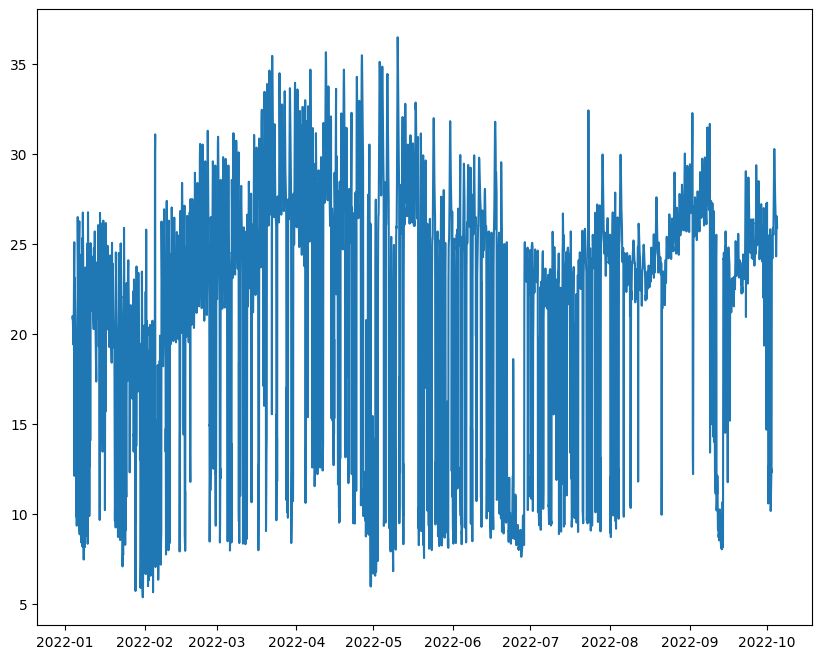

In [12]:
# plot the time series plot
plt.figure(figsize=(10,8))
plt.plot(train_data)

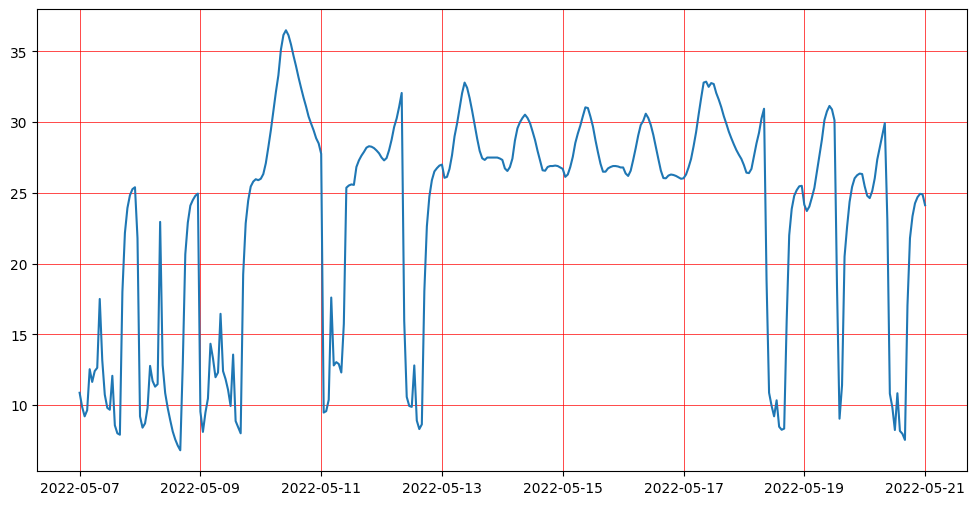

In [13]:
# plot a random N days
at_day = 123
duration_days = 14

plot_data = train_data.iloc[at_day*24:((at_day+duration_days)*24 + 1),0]
plt.figure(figsize=(12,6))
plt.plot(plot_data)

plt.grid(color='r', linestyle='-', linewidth=0.5)




Since we can see that from this period, the temperature appears to have specific pattern every day (raise-and-drop). It appears that, maybe seasonal pattern = 24 may exist

By visualization, it is pretty hard to tell if the time series data are stationary or not. What we can determine is the variability does not appear to change over time because the max-min diffrence for different time interval appears to be constant. For the mean, the time series plot shows a bit fluctation, we cannot conclude the mean remains constant (just some random fluctation) or the mean shows up-and-down features over time.

Next take a look at the ACF plot

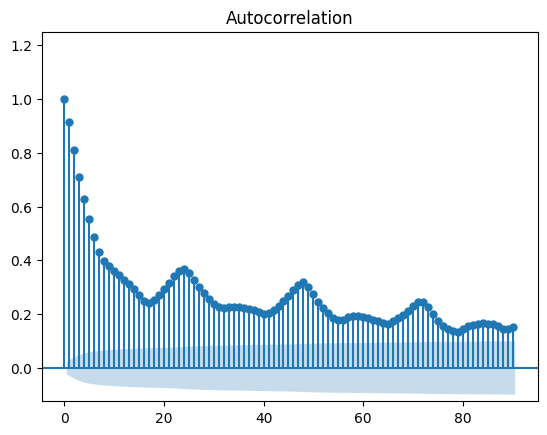

In [ ]:
# ACF plot
plot_acf(train_data, auto_ylims=True, lags=90)
plt.show()

The ACF decay slowly (and not even decay to zero in the long run), so we can conclude that the time series is not stationary. (We may observe that the ACF plot has slighly higher at lag=24, 48, ..., but we have no clear evidence here. We will perform further method to assess the seasonality later)

We may also see this using KPSS test:
\begin{align}
H_0 &: \text{the process is stationary} \\
H_1 &: \text{the process is non stationary}
\end{align}

p.s. alternative is ADF test, we can refer to the official [statsmodels website for test of stationarity](https://www.statsmodels.org/dev/examples/notebooks/generated/stationarity_detrending_adf_kpss.html)

In [ ]:
from statsmodels.tsa.stattools import kpss

kpss(train_data)

(0.6180951551042116,
 0.02099134953598076,
 46,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

The summary of KPSS test returned some info, in which the first is the test statistic; the second one is the p-value of the test.

Since the p-value is sufficiently small (\<0.05 and close to 0.01), we have sufficient evidence to reject $H_0$ and conclude that the underlying time series is non-stationary

# Further differencing, seasonality, and Auto-arima

Since we have conclude that the give time series data is nonstationary, we may try performing differencing to see if the differenced time series may show stationarity. We then see auto.arima may give us matching result

## First order differencing

In [ ]:
from statsmodels.tsa.statespace.tools import diff

diff_data = diff(train_data)

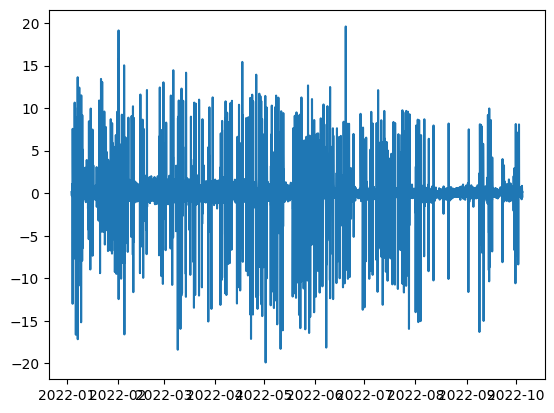

In [ ]:
# time series plot of the differenced data
plt.plot(diff_data)

looks somehow better since we can see the mean of the data shows around 0 over time

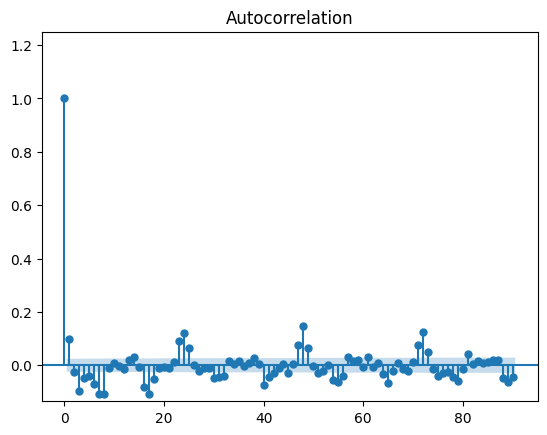

In [ ]:
# ACF plot
plot_acf(diff_data, auto_ylims=True, lags=90)
plt.show()

shows quite good as well as it decay to zero (again, observed a spike at the multiple of lag=24)


In [ ]:
# KPSS test
kpss(diff_data)

<ipython-input-17-dd1f5cbb2be3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss(diff_data)


(0.008602195483917649,
 0.1,
 89,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

the p-value of the KPSS test is 0.1 > 0.05, we failed to reject $H_0$ at 0.05 significance level.

According to the above findings, we can conclude that the differenced data is **stationary**

## Seasonality and seasonal order differencing

As we have seen that there appears to have seasonal (daily) pattern, it is also reasonable as the hour component should have high correlation between consecutive days (in reality, yearly pattern should also exist, but this dataset does not contain multiple years)

We will perform method to see if there have seasonal pattern

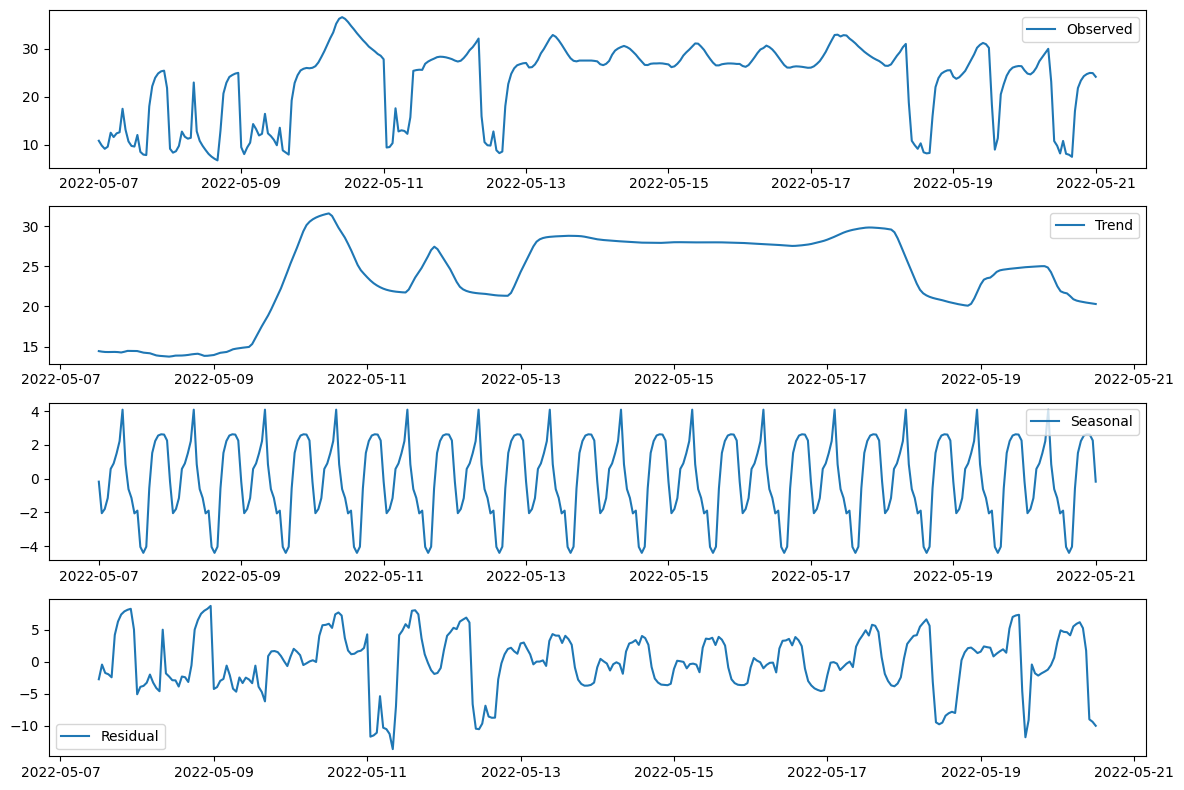

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

# perform seasonal decomposition under period=24, using additive model
decompo = seasonal_decompose(plot_data, model='additive')

# plot all relevants results
plt.figure(figsize=(12, 8))

plt.subplot(4, 1, 1)
plt.plot(decompo.observed, label='Observed')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(decompo.trend, label='Trend')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(decompo.seasonal, label='Seasonal')
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(decompo.resid, label='Residual')
plt.legend()

plt.tight_layout()
plt.show()

There is some resource that having indicator what if the data shows seasonality, see (Measuring Strength of trend and seasonality)[https://otexts.com/fpp2/seasonal-strength.html]

In [ ]:
Fs = max(0, 1 - np.var(decompo.resid) / np.var(decompo.seasonal + decompo.resid))

Fs

0.20683984661049515

Since the indicator around 0.2 > 0, although not very large, it may shows weak stationality

In [ ]:
# check also if the seasonal diff data is also stationary
kpss(diff(data, k_diff=1, k_seasonal_diff=1, seasonal_periods=24))

<ipython-input-20-63e354c4c782>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss(diff(data, k_diff=1, k_seasonal_diff=1, seasonal_periods=24))


(0.004275872565710428,
 0.1,
 56,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

p-value of the test is 0.1 > 0.05, so we fail to reject $H_0$, and conclude the seasonal diff with first order diff data is stationary

## Auto Arima

For R, there is a popular time series package **forecast**, in which provides a handy function called auto.arima for ARIMA order selection automatically. Although we should note that auto.arima provides us some insight for lowest AIC/BIC model, we should use it carefully to avoid choosing high complexity of model.

Similar package for Python is called **pmdarima**, see (pmdarima.arima.auto_arima)[https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html]


In [ ]:
# supply the data, and then auto_arima method will return the "best" order of the data

#!pip install pmdarima
#from pmdarima.arima import auto_arima
#auto_arima(train_data)

# this will suggest ARIMA(1,1,3)(0,0,0)[0]

In [ ]:
# because auto_arima is very slow, we will write the function by ourselves

Although auto_arima suggests an ARIMA(1,1,3) model. In common practice, we will choose the AR and MA order at most 2 if possible. So we will then try to look if lower order may give plausible result.

Also, to satisfy our claim with seasonal order=24, we will perform further investigation

To identify the order of autoregressive and moving average components, we have the following approach:

for pure MA(q) process, the ACF will have a clear cut-off after lag q
for pure AR(p) process, the PACF will have a clear cut-off after lag p

for ARMA process, we will see that both ACF and PACF should decay to 0 gradually, but not clear cut-off to be appeared

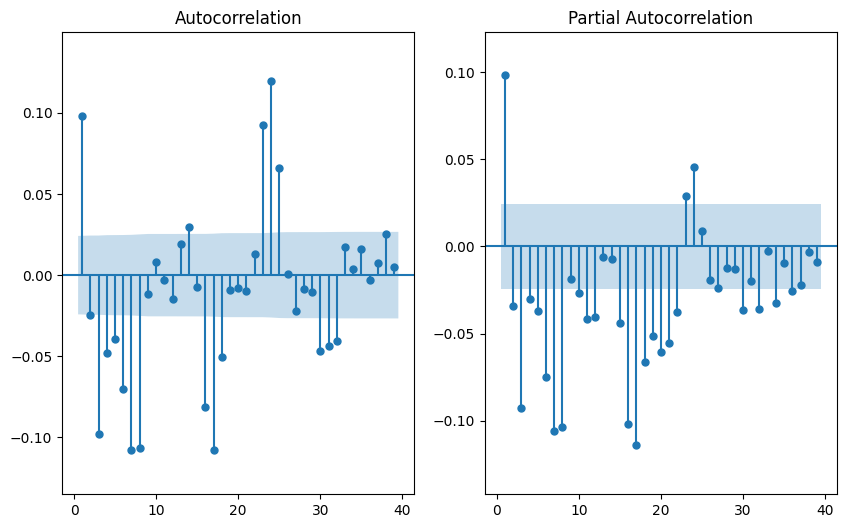

In [ ]:
## ACF and PACF plot of the differenced data
fig, (ax0, ax1) = plt.subplots(1,2, figsize=(10,6))
plot_acf(diff_data, ax=ax0, auto_ylims=True, zero=False) # for ACF, we can include or exclude lag-zero. The ACF of lag-zero is always 1
plot_pacf(diff_data, ax=ax1, auto_ylims=True, zero=False) # for PACF, we should exclude lag-zero

plt.show()

Since the process is stationary after first order differencing, so we can see that the ACF decay to zero as lag increases.

From these 2 plots, we see that the PACF doesn't decay to zero, and the ACF looks like close zero after lag 1, but it doesn't look having a clear cut-off.

So, the data appears to have both AR and MA components (also matching the auto-arima result)

# Fitting different models

Recall that the auto-arima suggests ARMA(1,3), however, we should try different models to see if introducing higher order can significantly reduce the AIC/BIC

We first starts with the lowest order fitting to differenced data

p.s. note that the coefficients of ar components needed to negate according to the official document (ARMA process)[https://www.statsmodels.org/dev/generated/statsmodels.tsa.arima_process.ArmaProcess.html]
also, both ar and ma component needed to add zero-lag coefficient

## Using ARIMA

In [ ]:
# define some handy method to simplify our works
from statsmodels.tsa.arima_process import arma_acf, arma_pacf
from statsmodels.tsa.arima.model import ARIMA

from sklearn.metrics import mean_squared_error

# training_data; nonseasonal orders, seasonal orders, test_data
def searching_arima(data, p, q, test_data, show_result=False):

  # recall that the ARMA process is stationarity if the roots of AR characteristic polynomial all lie outside the unit circle
  # is invertible if the roots of MA characteristic polynomial all lie outside the unit circle
  model = ARIMA(data, order=(p, 1, q), enforce_stationarity=True, enforce_invertibility=True)
  result = model.fit()

  if show_result:
    print(result.summary())

    fig, (ax0, ax1) = plt.subplots(1,2, figsize=(8,4))

    plot_acf(diff(data), ax=ax0, auto_ylims=True, zero=True, lags=30, label='sample ACF',) # for ACF, we can include or exclude lag-zero. The ACF of lag-zero is always 1
    ax0.plot(range(0, 30), arma_acf(result.polynomial_reduced_ar, result.polynomial_reduced_ma, lags=30), color='red', label='theoretical ACF')
    ax0.legend()

    plot_pacf(diff(data), ax=ax1, auto_ylims=True, zero=True, lags=30, label='sample PACF') # for PACF, we can exclude lag-zero if necessary
    ax1.plot(range(0, 30), arma_pacf(result.polynomial_reduced_ar, result.polynomial_reduced_ma, lags=30), color='red', label='theoretical PACF')
    ax1.legend()

    fig.suptitle('ARIMA(%s,1,%s)' % (p, q))
    plt.show()


  # prediction
  prediction = result.get_forecast(steps=test_data.shape[0])
  mse = mean_squared_error(prediction.predicted_mean, test_data)

  return {'p': p, 'q': q, 'AIC': result.aic, 'AICc': result.aicc, 'BIC': result.bic, 'test_mse': mse, 'model': result}



In [ ]:
arima_search_list = []
for p in range(0,4):
  for q in range(0,4):
    print('running (p,q)=(%s,%s)' % (p,q))
    try:
      print("***************************")
      df = searching_arima(train_data, p, q, test_data)
      arima_search_list.append(df)
      print("***************************")
    except:
      print('the process is not feasible: (p,q)=(%s,%s)' % (p,q))


arima_search_df = pd.DataFrame(arima_search_list)
arima_search_df.index = arima_search_df[['p','q']].apply(lambda x: '(%s,%s)' % (x['p'],x['q']), axis=1)


running (p,q)=(0,0)
***************************


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


***************************
running (p,q)=(0,1)
***************************


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


***************************
running (p,q)=(0,2)
***************************


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


***************************
running (p,q)=(0,3)
***************************


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


***************************
running (p,q)=(1,0)
***************************


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


***************************
running (p,q)=(1,1)
***************************


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


***************************
running (p,q)=(1,2)
***************************


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


***************************
running (p,q)=(1,3)
***************************


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


***************************
running (p,q)=(2,0)
***************************


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


***************************
running (p,q)=(2,1)
***************************


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using

***************************
running (p,q)=(2,2)
***************************


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


***************************
running (p,q)=(2,3)
***************************


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using

***************************
running (p,q)=(3,0)
***************************


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


***************************
running (p,q)=(3,1)
***************************


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


***************************
running (p,q)=(3,2)
***************************


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


***************************
running (p,q)=(3,3)
***************************


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using

***************************


In [ ]:
# sort the DataFrame according to AIC
arima_search_df.sort_values(by=['AIC'])

,p,q,AIC,AICc,BIC,test_mse,model
"(1,3)",1,3,31976.316935,31976.326069,32010.272085,4.696400,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
"(2,3)",2,3,31976.885302,31976.898091,32017.631481,4.775962,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
"(3,2)",3,2,31977.325909,31977.338699,32018.072088,4.645688,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
"(3,3)",3,3,31978.745035,31978.762090,32026.282244,4.748637,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
"(3,1)",3,1,31980.015553,31980.024687,32013.970703,4.547110,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
"(2,2)",2,2,31981.690774,31981.699908,32015.645923,4.490591,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
"(2,1)",2,1,31990.074235,31990.080323,32017.238354,4.851915,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
"(1,2)",1,2,32010.630171,32010.636259,32037.794291,5.093243,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
"(0,3)",0,3,32349.499597,32349.505685,32376.663717,1.218117,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
"(3,0)",3,0,32350.261100,32350.267188,32377.425220,1.222165,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...


Since here we can also conclude that ARMA(1,3) has the lowest AIC (also AICc and BIC). All candidates with higher ar/ma orders can be ignored.

One maybe interested in is the models with total orders (p+q=4) slightly less order: i.e.
ARMA(1,2), ARMA(0,3), ARMA(2,1)

It is worth note that ARMA(0,3) has AIC 400 higher than ARMA(1,3), but its test_mse is just 25% that of ARMA(1,3), so we may also consider it.

Here, we do not consider ARMA(2,2) as if we accept total order=4, we should rather consider ARMA(1,3) as it has the lowest AIC/BIC

In [ ]:
# sort the DataFrame according to AIC
arima_search_df2 = arima_search_df.loc[['(1,3)', '(1,2)', '(0,3)', '(2,1)']]

arima_search_df2

,p,q,AIC,AICc,BIC,test_mse,model
"(1,3)",1,3,31976.316935,31976.326069,32010.272085,4.696400,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
"(1,2)",1,2,32010.630171,32010.636259,32037.794291,5.093243,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
"(0,3)",0,3,32349.499597,32349.505685,32376.663717,1.218117,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
"(2,1)",2,1,31990.074235,31990.080323,32017.238354,4.851915,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...


All these 4 models seemed not differ a lot in AIC, AICc and BIC.

We revisit the model summary

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:            temperature   No. Observations:                 6576
Model:                 ARIMA(1, 1, 3)   Log Likelihood              -15983.158
Date:                Tue, 13 Feb 2024   AIC                          31976.317
Time:                        21:23:52   BIC                          32010.272
Sample:                    01-04-2022   HQIC                         31988.054
                         - 10-04-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8224      0.010     84.748      0.000       0.803       0.841
ma.L1         -0.7831      0.011    -74.500      0.000      -0.804      -0.763
ma.L2         -0.1126      0.010    -10.729      0.0

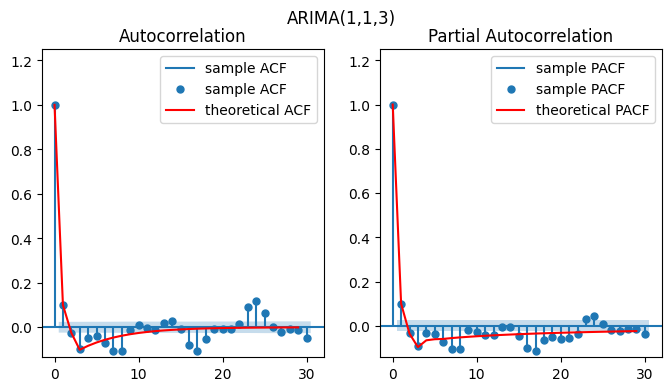

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using

                               SARIMAX Results                                
Dep. Variable:            temperature   No. Observations:                 6576
Model:                 ARIMA(2, 1, 1)   Log Likelihood              -15991.037
Date:                Tue, 13 Feb 2024   AIC                          31990.074
Time:                        21:23:54   BIC                          32017.238
Sample:                    01-04-2022   HQIC                         31999.464
                         - 10-04-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0314      0.009    120.892      0.000       1.015       1.048
ar.L2         -0.1640      0.007    -22.509      0.000      -0.178      -0.150
ma.L1         -0.9880      0.002   -469.828      0.0

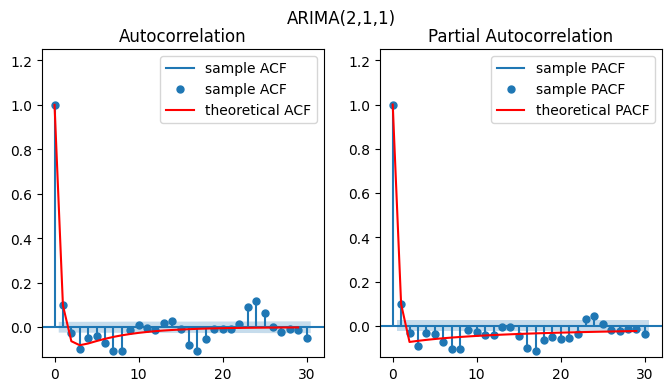

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:            temperature   No. Observations:                 6576
Model:                 ARIMA(1, 1, 2)   Log Likelihood              -16001.315
Date:                Tue, 13 Feb 2024   AIC                          32010.630
Time:                        21:23:56   BIC                          32037.794
Sample:                    01-04-2022   HQIC                         32020.020
                         - 10-04-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8560      0.008    109.246      0.000       0.841       0.871
ma.L1         -0.8287      0.009    -95.670      0.000      -0.846      -0.812
ma.L2         -0.1596      0.008    -19.980      0.0

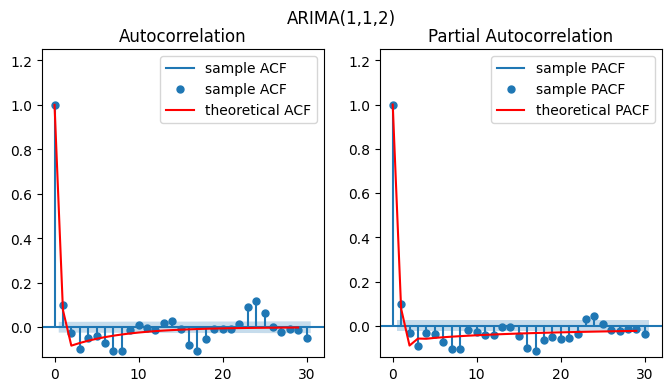

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:            temperature   No. Observations:                 6576
Model:                 ARIMA(0, 1, 3)   Log Likelihood              -16170.750
Date:                Tue, 13 Feb 2024   AIC                          32349.500
Time:                        21:23:57   BIC                          32376.664
Sample:                    01-04-2022   HQIC                         32358.889
                         - 10-04-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0873      0.008     11.469      0.000       0.072       0.102
ma.L2         -0.0298      0.011     -2.789      0.005      -0.051      -0.009
ma.L3         -0.1062      0.011    -10.056      0.0

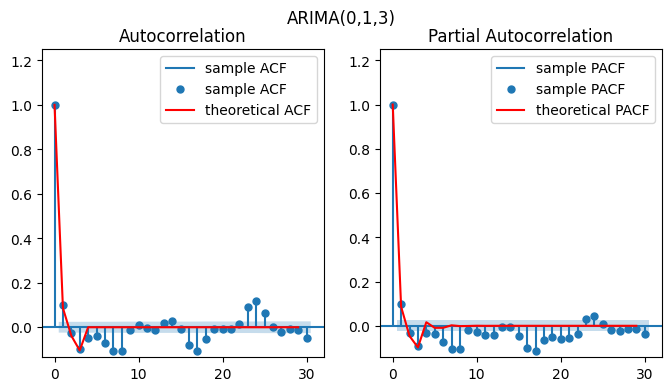

In [ ]:
ar1_ma3 = searching_arima(train_data, 1, 3, test_data, show_result=True)
ar2_ma1 = searching_arima(train_data, 2, 1, test_data, show_result=True)
ar1_ma2 = searching_arima(train_data, 1, 2, test_data, show_result=True)
ar0_ma3 = searching_arima(train_data, 0, 3, test_data, show_result=True)

All 3 models having a quite good fit of ACF and PACF plots. And from the statistical test, for each model, the parameter estimate of each AR/MA coefficients are significant.

Here we may conclude that all these 3 models can be our candidates. We then assess the test MSE and diagnostic analysis as well, to see which one if our best model

In [ ]:

def forecast_plot1(arima_models_df, train_data, test_data):

  plt.figure(figsize=(12,6))
  plt.plot(train_data[-100:], color='black', label="train_data")
  plt.plot(test_data, color='blue', label="test_data")
  plt.ylim([0,40])
  colors = ['red','green','brown', 'purple']
  for i in range(arima_models_df.shape[0]):
    row = arima_models_df.iloc[i]
    result = row['model']
    prediction = result.get_forecast(steps=test_data.shape[0])
    prediction = pd.concat((prediction.predicted_mean, prediction.conf_int(alpha=0.05)), axis=1)

    color = colors[i]
    plt.plot(prediction['predicted_mean'], color=color, label='ARMA(%s,%s) forecast' % (p,q))
    plt.plot(prediction['lower temperature'], color=color, linestyle='--', label='ARMA(%s,%s) 95 Bound' % (p,q))
    plt.plot(prediction['upper temperature'], color=color, linestyle='--')

  plt.legend()
  plt.show()




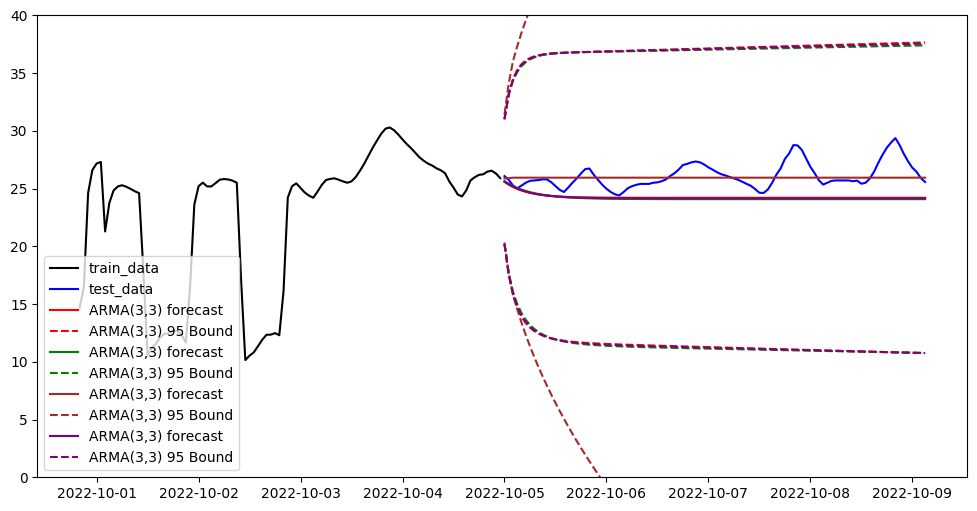

In [ ]:
forecast_plot1(arima_search_df2, train_data, test_data)

Although low test_mse, clearly these 4 models are not applicable as the test data and the forecasted data are not close.


Next look at with seasonality

## Using SARIMA

fitting SARIMA, but fixed first order differencing = 1; seasonal order differencing = 1; seasonal period = 24

In [ ]:
# define some handy method to simplify our works
from statsmodels.tsa.statespace.sarimax import SARIMAX


# training_data; nonseasonal orders, seasonal orders, test_data
def searching_sarima(data, p, q, P, Q, test_data, show_result=False):
  print("running")
  model = SARIMAX(data, order=(p, 1, q), seasonal_order=(P, 1, Q, 24), enforce_stationarity=True, enforce_invertibility=True)
  result = model.fit()

  if show_result:
    print(result.summary())

    fig, (ax0, ax1) = plt.subplots(1,2, figsize=(8,4))
    plot_acf(diff(data, k_diff=1, k_seasonal_diff=1, seasonal_periods=24), ax=ax0, auto_ylims=True, zero=True, lags=30, label='sample ACF',) # for ACF, we can include or exclude lag-zero. The ACF of lag-zero is always 1
    ax0.plot(range(0, 30), arma_acf(result.polynomial_reduced_ar, result.polynomial_reduced_ma, lags=30), color='red', label='theoretical ACF')
    ax0.legend()

    plot_pacf(diff(data, k_diff=1, k_seasonal_diff=1, seasonal_periods=24), ax=ax1, auto_ylims=True, zero=True, lags=30, label='sample PACF') # for PACF, we can exclude lag-zero if necessary
    ax1.plot(range(0, 30), arma_pacf(result.polynomial_reduced_ar, result.polynomial_reduced_ma, lags=30), color='red', label='theoretical PACF')
    ax1.legend()

    fig.suptitle('SARIMA(%s,1,%s)(%s,1,%s)[24]' % (p,q,P,Q))
    plt.show()


  # prediction
  prediction = result.forecast(steps=test_data.shape[0])
  mse = mean_squared_error(prediction, test_data)

  return {'p': p, 'q': q, 'P': P, 'Q': Q, 'AIC': result.aic, 'AICc': result.aicc, 'BIC': result.bic, 'test_mse': mse}


In [ ]:
sarima_search_list = []
# usually, the seasonal order should not larger than 1

# to avoid running out of memory, spilt the process for (P,Q)=(0,0),(0,1),(1,0),(1,1)

def different_P_Q(P,Q):
  for p in range(0,4):
    for q in range(0,4):
      print('running (p,q,P,Q)=(%s,%s,%s,%s)' % (p,q,P,Q))
#      try:
      print("***************************")
      df = searching_sarima(train_data, p, q, P, Q,test_data)
      print("***************************")
      sarima_search_list.append(df)
 #     except:
 #       print('the process is not feasible: (p,q,P,Q)=(%s,%s,%s,%s)' % (p,q,P,Q))


In [ ]:
# P=0, Q=0
different_P_Q(0,0)

len(sarima_search_list)


In [ ]:
# P=0, Q=1
different_P_Q(0,1)

len(sarima_search_list)

In [ ]:
# P=1, Q=0
different_P_Q(1,0)

len(sarima_search_list)

In [ ]:
# P=1, Q=1
different_P_Q(1,1)

len(sarima_search_list)

In [ ]:

sarima_search_df = pd.DataFrame(sarima_search_list)
sarima_search_df.index = sarima_search_df[['p','q','P','Q']].apply(lambda x: '(%s,%s,%s,%s)' % (x['p'],x['q'],x['P'],x['Q']), axis=1)


In [ ]:
#sarima_search_df.to_pickle("temp_file")

Note that some model has lower AIC but with higher test_mse, they may show better fit with the training data, but worse to predict the future.

To balance the 2 metrics, we may first consider lower test_mse as possible, then choose the model with lower AIC.

In [ ]:
sarima_search_df.sort_values('AIC').head(30)

,p,q,P,Q,AIC,AICc,BIC,test_mse
"(2,3,0,1)",2,3,0,1,31719.388730,31719.405847,31766.900341,4.925965
"(3,3,0,1)",3,3,0,1,31720.502396,31720.524407,31774.801380,5.008920
"(2,3,1,1)",2,3,1,1,31720.631077,31720.653089,31774.930061,4.922651
"(1,3,0,1)",1,3,0,1,31721.601826,31721.614662,31762.326064,4.840363
"(3,3,1,1)",3,3,1,1,31721.696377,31721.723895,31782.782734,5.006093
"(3,2,0,1)",3,2,0,1,31721.956756,31721.973874,31769.468367,4.860936
"(1,3,1,1)",1,3,1,1,31722.888569,31722.905686,31770.400180,4.837882
"(3,2,1,1)",3,2,1,1,31723.225479,31723.247490,31777.524463,4.859007
"(3,1,0,1)",3,1,0,1,31725.652545,31725.665381,31766.376783,4.828934
"(3,1,1,1)",3,1,1,1,31726.937341,31726.954459,31774.448952,4.829509


In [ ]:
sarima_search_df.sort_values('test_mse').head(30)

,p,q,P,Q,AIC,AICc,BIC,test_mse
"(3,3,1,0)",3,3,1,0,33575.345053,33575.367065,33629.644037,0.808577
"(2,2,1,0)",2,2,1,0,33602.793530,33602.806366,33643.517768,0.827695
"(2,3,1,0)",2,3,1,0,33569.427140,33569.444258,33616.938751,0.857020
"(3,2,1,0)",3,2,1,0,33565.215906,33565.233023,33612.727517,0.863553
"(1,2,1,0)",1,2,1,0,33642.873188,33642.882356,33676.810053,0.872647
"(2,1,1,0)",2,1,1,0,33638.514042,33638.523210,33672.450907,0.879390
"(3,1,1,0)",3,1,1,0,33633.777799,33633.790635,33674.502037,0.890375
"(1,3,1,0)",1,3,1,0,33632.072109,33632.084945,33672.796347,0.896427
"(3,1,0,0)",3,1,0,0,35617.183514,35617.192681,35651.120379,1.146742
"(3,3,0,0)",3,3,0,0,35615.504345,35615.521463,35663.015956,1.150279


We can see that some model can have test_mse is below 1. Again as we emphazise, we should always seek for parsimonious model.

Some model may worth pointing out:

I will choose the following for to investigate:

for low AIC:
1. ARIMA(2,1,3)(0,1,1)[24], lowest AIC for SARIMA
2. ARIMA(1,1,3)(0,1,1)[24], which is lowest AIC for the ARIMA but with extra seasonal differencing and an extra seasonal MA
3. ARIMA(1,1,3)(1,1,1)[24], which is lowest AIC for the ARIMA but with extra seasonal differencing and extra seasonal AR and MA

for low test_mse
1. ARIMA(3,1,3)(1,1,0)[24], lowest test mse for SARIMA
2. ARIMA(1,1,2)(1,1,0)[24], low test mse but far less parameters
2. ARIMA(2,1,1)(1,1,0)[24], low test mse but far less parameters
2. ARIMA(1,1,3)(0,1,0)[24], which is the lowest AIC for the ARIMA but with seasonal differencing





p.s. We cannot compare the AIC with **different differencing order**, we cannot just comparing the AIC with ARIMA and SARIMA

In [ ]:
sarima_search_df2 = sarima_search_df.loc[['(2,3,0,1)', '(1,3,0,1)', '(1,3,1,1)',
                                          '(3,3,1,0)', '(1,2,1,0)','(2,1,1,0)', '(1,3,0,0)']]
sarima_search_df2

,p,q,P,Q,AIC,AICc,BIC,test_mse
"(2,3,0,1)",2,3,0,1,31719.388730,31719.405847,31766.900341,4.925965
"(1,3,0,1)",1,3,0,1,31721.601826,31721.614662,31762.326064,4.840363
"(1,3,1,1)",1,3,1,1,31722.888569,31722.905686,31770.400180,4.837882
"(3,3,1,0)",3,3,1,0,33575.345053,33575.367065,33629.644037,0.808577
"(1,2,1,0)",1,2,1,0,33642.873188,33642.882356,33676.810053,0.872647
"(2,1,1,0)",2,1,1,0,33638.514042,33638.523210,33672.450907,0.879390
"(1,3,0,0)",1,3,0,0,35614.716242,35614.725409,35648.653107,1.151719


In [ ]:
# df with p,q,P,Q (as we used 1 seasonal order differencing)
# plot together with the previous results

def forecast_plot2(sarima_models_df, train_data, test_data):

  plt.figure(figsize=(14,10))
  plt.ylim(-5,45)
  plt.plot(train_data[-200:], color='black', label="train_data")
  plt.plot(test_data, color='blue', label="test_data")
  colors = ['red','green','brown', 'purple', 'yellow', 'pink', 'gray', 'olive', 'navy', 'teal', 'aqua']

  for j in range(sarima_models_df.shape[0]):
    p = sarima_models_df.iloc[j, 0]
    q = sarima_models_df.iloc[j, 1]
    P = sarima_models_df.iloc[j, 2]
    Q = sarima_models_df.iloc[j, 3]
    print('running at row index j, (p,q,P,Q)=(%s,%s,%s,%s)' % (p,q,P,Q))

    model = SARIMAX(train_data, order=(p, 1, q), seasonal_order=(P, 1, Q, 24), enforce_stationarity=True, enforce_invertibility=True)
    result = model.fit()

    prediction = result.get_forecast(steps=test_data.shape[0])
    prediction = pd.concat((prediction.predicted_mean, prediction.conf_int(alpha=0.05)), axis=1)

    color = colors[j]
    plt.plot(prediction['predicted_mean'], color=color, label='ARIMA(%s,1,%s)(%s,1,%s)[24] forecast' % (p,q,P,Q))
    plt.plot(prediction['lower temperature'], color=color, linestyle='--', label='ARIMA(%s,1,%s)(%s,1,%s)[24] 95 Bound' % (p,q,P,Q))
    plt.plot(prediction['upper temperature'], color=color, linestyle='--')


  plt.legend()
  plt.show()




running at row index j, (p,q,P,Q)=(2,3,0,1)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


running at row index j, (p,q,P,Q)=(1,3,0,1)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


running at row index j, (p,q,P,Q)=(1,3,1,1)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


running at row index j, (p,q,P,Q)=(3,3,1,0)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


running at row index j, (p,q,P,Q)=(1,2,1,0)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


running at row index j, (p,q,P,Q)=(2,1,1,0)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimiz

running at row index j, (p,q,P,Q)=(1,3,0,0)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


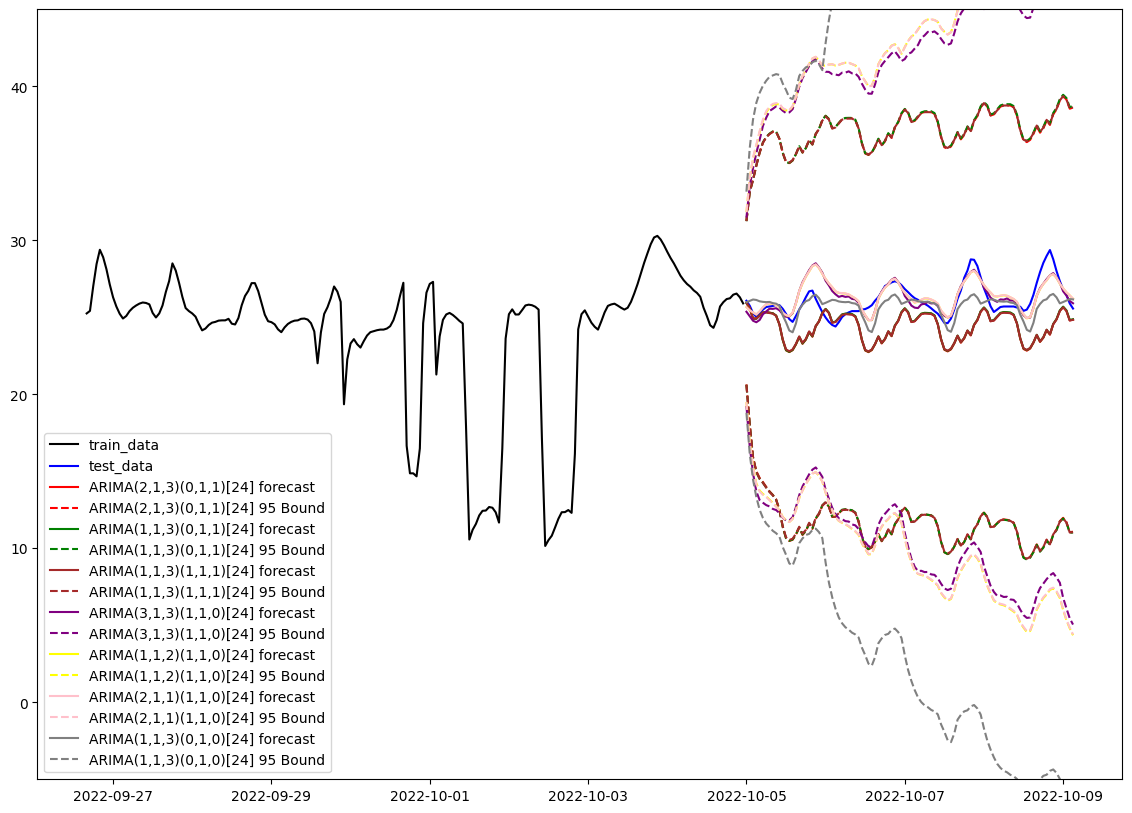

In [ ]:
forecast_plot2(sarima_search_df2, train_data, test_data)

By visual inspection, the following models fit the test data well:
1. ARIMA(1,1,2)(1,1,0)[24] (yellow line)
2. ARIMA(2,1,1)(1,1,0)[24] (pink line)
3. ARIMA(3,1,3)(1,1,0)[24] (purple line)

then revisit the summary dataframe

In [ ]:
sarima_search_df2.loc[['(1,2,1,0)', '(2,1,1,0)', '(3,3,1,0)']]

,p,q,P,Q,AIC,AICc,BIC,test_mse
"(1,2,1,0)",1,2,1,0,33642.873188,33642.882356,33676.810053,0.872647
"(2,1,1,0)",2,1,1,0,33638.514042,33638.523210,33672.450907,0.879390
"(3,3,1,0)",3,3,1,0,33575.345053,33575.367065,33629.644037,0.808577


Which make sense because these 3 models are the lowest mse among our 7 candidates search result.

Although the model ARIMA(3,1,3)(1,1,0)[24] has the lowest test_mse here, but the remaining 2 has 3 less parameters, so choose the remaining 2 should be the best choice.


In [ ]:

def forecast_plot3(sarima_models_df, train_data, test_data, forecast_days):

  plt.figure(figsize=(14,10))
  plt.ylim(-5,45)
  plt.plot(train_data[-200:], color='black', label="train_data")
  plt.plot(test_data, color='blue', label="test_data")
  colors = ['red','green','brown', 'purple', 'yellow', 'pink', 'gray', 'olive', 'navy', 'teal', 'aqua']

  for j in range(sarima_models_df.shape[0]):
    p = sarima_models_df.iloc[j, 0]
    q = sarima_models_df.iloc[j, 1]
    P = sarima_models_df.iloc[j, 2]
    Q = sarima_models_df.iloc[j, 3]
    print('running at row index j, (p,q,P,Q)=(%s,%s,%s,%s)' % (p,q,P,Q))

    model = SARIMAX(train_data, order=(p, 1, q), seasonal_order=(P, 1, Q, 24), enforce_stationarity=True, enforce_invertibility=True)
    result = model.fit()

    prediction = result.get_forecast(steps=test_data.shape[0] + forecast_days * 24)
    prediction = pd.concat((prediction.predicted_mean, prediction.conf_int(alpha=0.05)), axis=1)

    color = colors[j]
    plt.plot(prediction['predicted_mean'], color=color, label='ARIMA(%s,1,%s)(%s,1,%s)[24] forecast' % (p,q,P,Q))
    plt.plot(prediction['lower temperature'], color=color, linestyle='--', label='ARIMA(%s,1,%s)(%s,1,%s)[24] 95 Bound' % (p,q,P,Q))
    plt.plot(prediction['upper temperature'], color=color, linestyle='--')


  plt.legend()
  plt.show()





running at row index j, (p,q,P,Q)=(1,2,1,0)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


running at row index j, (p,q,P,Q)=(2,1,1,0)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimiz

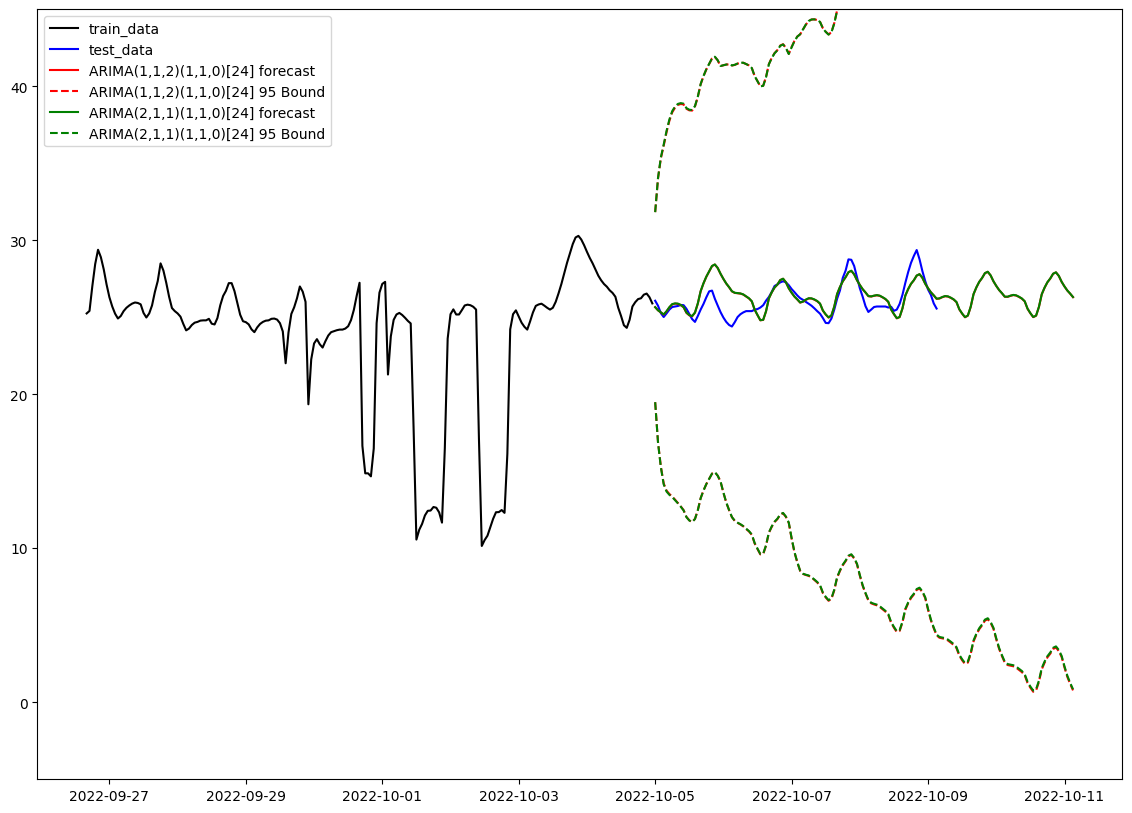

In [ ]:
forecast_plot3(sarima_search_df2.loc[['(1,2,1,0)', '(2,1,1,0)']],train_data, test_data, 2)

Both models look very similar. However, for execution time, the second model takes more than 3 times than that of the first model (converges issue). So, the models 1: ARIMA(1,1,2)(1,1,0)[24] should be a better choice




# Diagnostic Analysis

For time series analysis, the 3 diagnostic test are related to residuals:
1. time plot of the residuals looks like white noise
2. ACF of residuals is small for lag >=1
3. p-value of Ljung-Box test for different lags are large (typically > 0.05)




## Time plot of the residuals

In [ ]:
# extract the residuals
model = SARIMAX(train_data, order=(1, 1, 2), seasonal_order=(1, 1, 0, 24), enforce_stationarity=True, enforce_invertibility=True)
result = model.fit()

residuals = result.resid


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


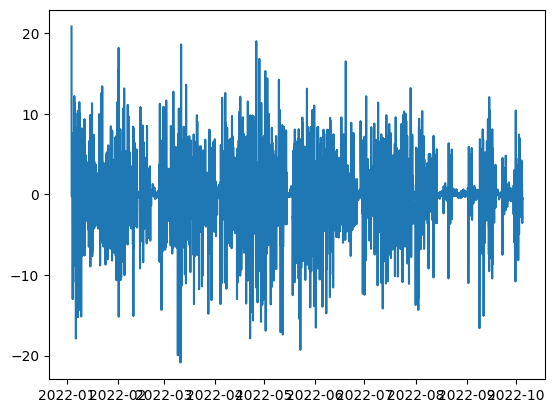

In [ ]:
# time series plot of the residuals
plt.plot(residuals)

Roughly speaking, the mean is 0 and the variability seemed quite consistent over different periods. So we may believe that the residuals looks like white noise

## ACF of residuals

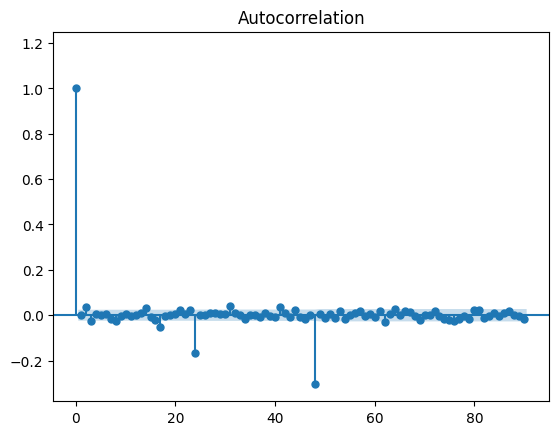

In [ ]:
# ACF plot
plot_acf(residuals, auto_ylims=True, lags=90)
plt.show()

Except at the seasonality lag, the ACF of the residuals fall close to zero

## Ljung-Box test

Ljung-Box test is the significant test of:

\begin{align}
H_0 &: \text{the residuals are independent} \\
H_1 &: \text{the residuals are not independent}
\end{align}


If the residuals are independent, we need the p-value of the test > 0.05

This information can be found in the fit summary

In [ ]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                         temperature   No. Observations:                 6576
Model:             SARIMAX(1, 1, 2)x(1, 1, [], 24)   Log Likelihood              -16816.437
Date:                             Wed, 14 Feb 2024   AIC                          33642.873
Time:                                     00:46:22   BIC                          33676.810
Sample:                                 01-04-2022   HQIC                         33654.606
                                      - 10-04-2022                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8685      0.006    145.565      0.000       0.857       0.880
ma.L1         -0.9055      0.042    -21.686      0.000      -0.987      -0.824
ma.L2         -0.0945      0.009     -9.946      0.000      -0.113      -0.076
ar.S.L24      -0.5118      0.006    -87.880      0.000      -0.523      -0.500
sigma2         9.9150      0.404     24.523      0.000       9.123      10.707
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):             11932.07
Prob(Q):                              0.77   Prob(JB):                         0.00
Heteroskedasticity (H):               0.58   Skew:                            -0.42
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

As the p-value Prob(Q) is 0.77 >> 0.05, we fail to reject $H_0$, so we conclude that the residuals are independent

# Conclusion

We tried several time series models to analyze the time series room temperature data. We have tried simple ARIMA model, although low test_mse, the forecast pattern does not fit the test data well (like simple horizontal straight line).

After that, we have tried seasonal ARIMA model, we have tried various non-seasonal order and seasonal order. We reached a pretty good model which fit the test data quite well (the daily fluctation pattern).

We then see that the candidate model satisfied the diagnostic tests.

So we conclude that the model

$$
ARIMA(1,1,2)(1,1,0)[24]
$$
can help model the room temperature data


And the parameter estimate of the model can be found from the fit summary

\begin{align}
\hat{\mu} &= 21.669442 \\
\hat{\phi_1} &= 0.8685 \\
\hat{\theta_1} &= -0.9055 \\
\hat{\theta_2} &= -0.0945 \\
\hat{\Phi_1} &= -0.5118 \\
\hat{\sigma^2} &= 9.9150
\end{align}


And the final model expression is

$$
(1-0.8685B)(1+0.5118B^{24})(1-B)(1-B^{24}) X_t = (1-0.9055B-0.0945B^2)Z_t
$$

where $Z_t \sim WN(0, 9.9150)$